In [5]:
# Installation des dépendances
!pip install torch torchvision matplotlib pandas tqdm

In [6]:
# Imports des bibliothèques essentiels
import os
import random
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder

**torch** : pour le cœur du deep learning et du modèle ResNet-50.

**torchvision** : pour les jeux de données, les transformations d’images et les modèles pré-entraînés.

**matplotlib** : pour la visualisation (affichage d’images, de courbes, etc.).

**pandas** : pour manipuler les métadonnées (CSV du dataset CUB).

**tqdm** : pour les barres de progression pendant l’entraînement.

**os, random** : gestion des fichiers, chemins et génération pseudo-aléatoire (utile pour la reproductibilité).

**matplotlib.pyplot, PIL.Image** visualisation et affichage des images et prédictions.

In [7]:
# Vérification du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé : {device}")

# Création du répertoire principal
base_dir = "/content/CUB_200_2011"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
print(f"Répertoire de travail : {base_dir}")

Appareil utilisé : cuda
Répertoire de travail : /content/CUB_200_2011


In [8]:
import zipfile
import urllib.request

url = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz"
dataset_path = "/content/CUB_200_2011.tgz"

# Téléchargement
if not os.path.exists(dataset_path):
    print("Téléchargement du dataset CUB_200_2011...")
    urllib.request.urlretrieve(url, dataset_path)
    print("Téléchargement terminé.")
else:
    print("Dataset déjà téléchargé.")

# Extraction
import tarfile

if not os.path.exists(os.path.join(base_dir, "images")):
    print("Extraction en cours...")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path="/content/")
    print("Extraction terminée !")
else:
    print("Dataset déjà extrait.")

# Vérification du contenu
print("\nContenu du dossier :")
print(os.listdir(base_dir)[:10])

Téléchargement du dataset CUB_200_2011...
Téléchargement terminé.
Extraction en cours...


/tmp/ipython-input-97561034.py:21: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="/content/")


Extraction terminée !

Contenu du dossier :
['README', 'image_class_labels.txt', 'classes.txt', 'images.txt', 'attributes', 'images', 'parts', 'bounding_boxes.txt', 'train_test_split.txt']


# **Chargement et préparation des métadonnées du dataset CUB-200-2011**

In [9]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

# Dossier des images
images_root = "/content/CUB_200_2011/images"

# Charger les métadonnées : classes et labels
image_labels = pd.read_csv("/content/CUB_200_2011/image_class_labels.txt",
                           sep=" ", header=None, names=["image_id", "class_id"])
image_paths = pd.read_csv("/content/CUB_200_2011/images.txt", sep=" ", header=None, names=["image_id", "rel_path"])

metadata = pd.merge(image_paths, image_labels, on="image_id")
metadata.head()

,image_id,rel_path,class_id
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1


Cette fusion prépare la base d’annotations unique utilisée par le Dataset PyTorch.

# **Personalisation du dataset pour PyTorch**

In [10]:
class CUBDataset(Dataset):
    def __init__(self, metadata, images_root, transform=None):
        self.metadata = metadata
        self.images_root = images_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_root, self.metadata.iloc[idx]["rel_path"])
        image = Image.open(img_path).convert("RGB")
        label = self.metadata.iloc[idx]["class_id"] - 1

        if self.transform:
            image = self.transform(image)
        return image, label

`__init__ Initialisation du dataset`

**metadata** : le DataFrame fusionné que tu as créé précédemment (image_id, rel_path, class_id).

**images_root** : chemin du répertoire principal contenant toutes les images.

**transform** : ensemble d’opérations (redimensionnement, normalisation, etc.) appliquées à chaque image avant qu’elle ne soit renvoyée.

`__len__ Taille du dataset`

Ceci permet à PyTorch de connaître le nombre total d’échantillons disponibles. Il est aussi utilisé notamment par le DataLoader pour le découpage en batchs.

`__getitem__ Chargement d’un échantillon individuel`

**idx** : index d’un échantillon dans le DataFrame.

**img_path** : construit le chemin absolu de l’image en combinant le dossier racine et le chemin relatif.

**Image.open(...).convert("RGB")** : lecture de l’image et conversion en format RGB.

**label = class_id - 1** : conversion en index 0-based (Car PyTorch exige que les classes soient de 0 à N-1).

Application éventuelle des transformations (resize, normalization, etc.).

**Préparation des transformations d’images**

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Détail de chaque transformation :**

| Étape                    | Description                                                        | But                                                                     |
| ------------------------ | ------------------------------------------------------------------ | ----------------------------------------------------------------------- |
| `Resize((224, 224))`     | Redimensionne toutes les images à 224×224 pixels                   | Taille d’entrée standard pour ResNet50                                  |
| `RandomHorizontalFlip()` | Fait une symétrie horizontale aléatoire de l’image                 | Augmentation de données → rend le modèle robuste à l’orientation        |
| `ColorJitter(...)`       | Modifie aléatoirement la luminosité, le contraste et la saturation | Simule différentes conditions lumineuses                                |
| `ToTensor()`             | Convertit l’image PIL (0–255) en tenseur PyTorch (0–1)             | Format attendu par le modèle                                            |
| `Normalize(mean, std)`   | Normalise les canaux RGB                                           | Aligne les données avec celles du pré-entraînement de ResNet (ImageNet) |


**Séparation en train et validation**

In [12]:
batch_size = 16

# Séparation du train et de la validation
train_meta = metadata.sample(frac=0.8, random_state=42)
val_meta = metadata.drop(train_meta.index)

# Création des datasets PyTorch
train_dataset = CUBDataset(train_meta, images_root, transform=train_transform)
val_dataset = CUBDataset(val_meta, images_root, transform=val_transform)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Nombre d'images train: {len(train_dataset)}")
print(f"Nombre d'images val:   {len(val_dataset)}")

Nombre d'images train: 9430
Nombre d'images val:   2358


**batch_size 16** : pour que le modèle traite 16 images à la fois avant de faire une mise à jour des poids.

**Séparation en train et validation**

| Élément                  | Description                                               |
| ------------------------ | --------------------------------------------------------- |
| `frac=0.8`               | On prend 80% des données pour l’entraînement.             |
| `drop(train_meta.index)` | Les 20% restants deviennent le jeu de validation.         |
| `random_state=42`        | Graine aléatoire fixe → garantit la **reproductibilité**. |

**Création des DataLoaders**

| Paramètre       | Description                                                                |
| --------------- | -------------------------------------------------------------------------- |
| `batch_size=16` | Nombre d’images traitées simultanément                                     |
| `shuffle=True`  | Mélange les images à chaque epoch → évite l’ordre fixe                     |
| `num_workers=2` | Nombre de processus parallèles pour charger les données (accélère sur GPU) |


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Détection du device utilisé
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé : {device}")

# Chargement du ResNet-50 pré-entraîné
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Adaptation de la couche finale au nombre de classes du dataset CUB
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Envoi du modèle sur le device
model = model.to(device)

# Critère et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour sauvegarder le checkpoint
def save_checkpoint(model, path="resnet50_cub.pth"):
    torch.save(model.state_dict(), path)
    print(f"Modèle sauvegardé dans {path}")

Appareil utilisé : cuda


# **Entraînement du modèle**

In [14]:
import time
import copy
import matplotlib.pyplot as plt

# --- 1. DÉFINITION DE LA FONCTION D'ENTRAÎNEMENT (AVEC VALIDATION) ---
def train_segment(model, loader_train, loader_val, criterion, optimizer, num_epochs, phase_name=""):
    since = time.time()

    # Historique pour ce segment
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'{phase_name} Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Chaque epoch a une phase d'entraînement et de validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = loader_train
            else:
                model.eval()
                dataloader = loader_val

            running_loss = 0.0
            running_corrects = 0

            # Boucle sur les données
            for inputs, labels in tqdm(dataloader, desc=f"{phase}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize seulement si train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistiques
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Stockage
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Sauvegarde du meilleur modèle
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'{phase_name} terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s. Best Val Acc: {best_acc:.4f}')

    # On charge les meilleurs poids de ce segment
    model.load_state_dict(best_model_wts)
    return model, history

# --- 2. EXÉCUTION DU PIPELINE (PHASE 1 + PHASE 2) ---

# Paramètres
num_epochs_head = 5
num_epochs_full = 10

# Global History (pour fusionner les deux phases)
full_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# === PHASE 1 : Entraînement de la tête seulement ===
print("\n=== PHASE 1 : Feature Extraction (Tête seulement) ===")
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# On s'assure que l'optimiseur ne voit que la tête pour l'instant (optionnel mais propre)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

model, hist1 = train_segment(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs_head, phase_name="Ph1")

# Ajout à l'historique global
for k in full_history:
    full_history[k].extend(hist1[k])

# === PHASE 2 : Fine-tuning complet ===
print("\n=== PHASE 2 : Fine-tuning complet ===")
for param in model.parameters():
    param.requires_grad = True

# On recrée l'optimiseur pour qu'il prenne en compte TOUS les paramètres maintenant, avec un LR plus faible
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model, hist2 = train_segment(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs_full, phase_name="Ph2")

# Ajout à l'historique global
for k in full_history:
    full_history[k].extend(hist2[k])

# Sauvegarde finale
save_checkpoint(model, path="/content/resnet50_cub.pth")


=== PHASE 1 : Feature Extraction (Tête seulement) ===
Ph1 Epoch 1/5
----------


train: 100%|██████████| 590/590 [01:06<00:00,  8.81it/s]


train Loss: 3.7039 Acc: 0.2251


val: 100%|██████████| 148/148 [00:12<00:00, 11.79it/s]


val Loss: 2.4430 Acc: 0.4046
Ph1 Epoch 2/5
----------


train: 100%|██████████| 590/590 [01:06<00:00,  8.91it/s]


train Loss: 2.0185 Acc: 0.4874


val: 100%|██████████| 148/148 [00:12<00:00, 11.93it/s]


val Loss: 2.1342 Acc: 0.4449
Ph1 Epoch 3/5
----------


train: 100%|██████████| 590/590 [01:06<00:00,  8.88it/s]


train Loss: 1.6192 Acc: 0.5777


val: 100%|██████████| 148/148 [00:12<00:00, 11.78it/s]


val Loss: 2.0299 Acc: 0.4885
Ph1 Epoch 4/5
----------


train: 100%|██████████| 590/590 [01:05<00:00,  9.01it/s]


train Loss: 1.3884 Acc: 0.6230


val: 100%|██████████| 148/148 [00:12<00:00, 11.66it/s]


val Loss: 1.9750 Acc: 0.5059
Ph1 Epoch 5/5
----------


train: 100%|██████████| 590/590 [01:05<00:00,  8.95it/s]


train Loss: 1.2354 Acc: 0.6551


val: 100%|██████████| 148/148 [00:12<00:00, 11.76it/s]


val Loss: 1.9570 Acc: 0.5170
Ph1 terminé en 6m 34s. Best Val Acc: 0.5170

=== PHASE 2 : Fine-tuning complet ===
Ph2 Epoch 1/10
----------


train: 100%|██████████| 590/590 [01:41<00:00,  5.79it/s]


train Loss: 1.0063 Acc: 0.7161


val: 100%|██████████| 148/148 [00:12<00:00, 11.64it/s]


val Loss: 1.1691 Acc: 0.6722
Ph2 Epoch 2/10
----------


train: 100%|██████████| 590/590 [01:41<00:00,  5.79it/s]


train Loss: 0.4974 Acc: 0.8565


val: 100%|██████████| 148/148 [00:12<00:00, 11.67it/s]


val Loss: 1.1420 Acc: 0.6815
Ph2 Epoch 3/10
----------


train: 100%|██████████| 590/590 [01:41<00:00,  5.79it/s]


train Loss: 0.3135 Acc: 0.9109


val: 100%|██████████| 148/148 [00:12<00:00, 11.48it/s]


val Loss: 1.1280 Acc: 0.7019
Ph2 Epoch 4/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.77it/s]


train Loss: 0.2304 Acc: 0.9379


val: 100%|██████████| 148/148 [00:12<00:00, 11.52it/s]


val Loss: 1.1322 Acc: 0.7235
Ph2 Epoch 5/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.75it/s]


train Loss: 0.1742 Acc: 0.9534


val: 100%|██████████| 148/148 [00:12<00:00, 11.53it/s]


val Loss: 1.1598 Acc: 0.6959
Ph2 Epoch 6/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.77it/s]


train Loss: 0.1772 Acc: 0.9516


val: 100%|██████████| 148/148 [00:13<00:00, 11.24it/s]


val Loss: 1.2224 Acc: 0.7019
Ph2 Epoch 7/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.76it/s]


train Loss: 0.1642 Acc: 0.9546


val: 100%|██████████| 148/148 [00:12<00:00, 11.42it/s]


val Loss: 1.2273 Acc: 0.7014
Ph2 Epoch 8/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.77it/s]


train Loss: 0.1290 Acc: 0.9656


val: 100%|██████████| 148/148 [00:12<00:00, 11.55it/s]


val Loss: 1.2789 Acc: 0.6968
Ph2 Epoch 9/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.77it/s]


train Loss: 0.1120 Acc: 0.9689


val: 100%|██████████| 148/148 [00:13<00:00, 11.38it/s]


val Loss: 1.2956 Acc: 0.6853
Ph2 Epoch 10/10
----------


train: 100%|██████████| 590/590 [01:42<00:00,  5.78it/s]


train Loss: 0.1407 Acc: 0.9610


val: 100%|██████████| 148/148 [00:12<00:00, 11.55it/s]


val Loss: 1.3142 Acc: 0.6930
Ph2 terminé en 19m 11s. Best Val Acc: 0.7235
Modèle sauvegardé dans /content/resnet50_cub.pth


Affichage des courbes d'apprentissage...


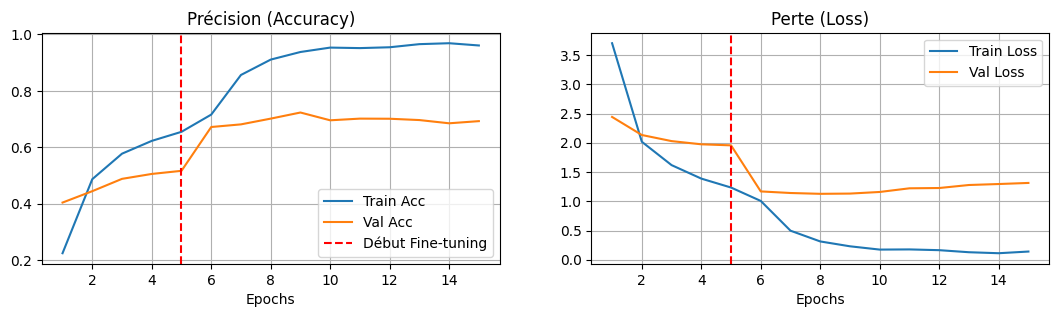

In [15]:
# --- 3. AFFICHAGE DES COURBES (POUR LE RAPPORT) ---
def plot_curves(history):
    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(13, 3))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    # Barre verticale pour montrer la séparation Phase 1 / Phase 2
    plt.axvline(x=num_epochs_head, color='r', linestyle='--', label='Début Fine-tuning')
    plt.title('Précision (Accuracy)')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.axvline(x=num_epochs_head, color='r', linestyle='--')
    plt.title('Perte (Loss)')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

print("Affichage des courbes d'apprentissage...")
plot_curves(full_history)

In [18]:
from sklearn.metrics import confusion_matrix

if 'idx_to_class' not in locals():
    classes_path = "/content/CUB_200_2011/classes.txt"
    classes_df = pd.read_csv(classes_path, sep=" ", header=None, names=["class_id", "class_name"])
    idx_to_class = {i: name.split('.')[1].replace('_', ' ') for i, name in enumerate(classes_df["class_name"])}

def show_top_confusions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    print("Calcul des confusions en cours...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Analyse"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Création de la matrice
    cm = confusion_matrix(all_labels, all_preds)

    # On met la diagonale à 0 pour ne garder que les erreurs
    np.fill_diagonal(cm, 0)

    # On récupère les indices des erreurs
    pairs = np.argwhere(cm > 0)
    confused_pairs = []
    for true_idx, pred_idx in pairs:
        count = cm[true_idx, pred_idx]
        confused_pairs.append((count, true_idx, pred_idx))

    # Tri décroissant (les plus grosses erreurs en premier)
    confused_pairs.sort(key=lambda x: x[0], reverse=True)

    print("\n--- TOP 5 DES CONFUSIONS ---")
    for count, true_idx, pred_idx in confused_pairs[:5]:
        true_name = idx_to_class[true_idx]
        pred_name = idx_to_class[pred_idx]
        print(f"⚠️ {count} erreurs : Vrai '{true_name}'  --->  Prédit '{pred_name}'")

# Exécution
show_top_confusions(model, val_loader)

Calcul des confusions en cours...


Analyse: 100%|██████████| 148/148 [00:13<00:00, 11.14it/s]



--- TOP 5 DES CONFUSIONS ---
⚠️ 9 erreurs : Vrai 'Brandt Cormorant'  --->  Prédit 'Pelagic Cormorant'
⚠️ 6 erreurs : Vrai 'Glaucous winged Gull'  --->  Prédit 'Western Gull'
⚠️ 6 erreurs : Vrai 'Philadelphia Vireo'  --->  Prédit 'Warbling Vireo'
⚠️ 5 erreurs : Vrai 'Rusty Blackbird'  --->  Prédit 'Brewer Blackbird'
⚠️ 5 erreurs : Vrai 'Least Flycatcher'  --->  Prédit 'Acadian Flycatcher'



--- EXEMPLES D'ERREURS VISUELLES ---


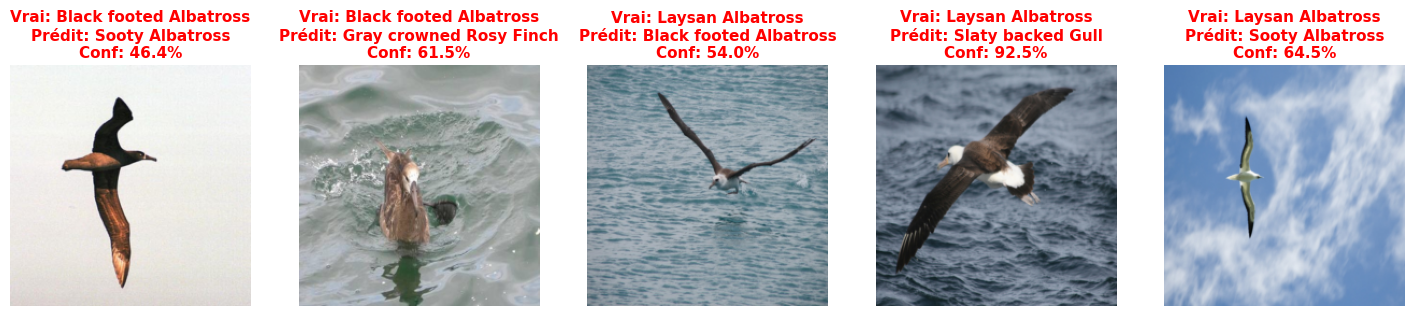

In [20]:
def show_misclassified_images(model, loader, num_images=5):
    model.eval()
    count = 0
    plt.figure(figsize=(18, 6))

    # Paramètres pour dé-normaliser l'image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    print("\n--- EXEMPLES D'ERREURS VISUELLES ---")
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, 1) # Pour avoir la confiance en %

            for i in range(images.size(0)):
                if preds[i] != labels[i]: # Si le modèle s'est trompé
                    count += 1
                    ax = plt.subplot(1, num_images, count)

                    # Traitement image
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    plt.imshow(img)
                    plt.axis('off')

                    # Infos
                    true_name = idx_to_class[labels[i].item()]
                    pred_name = idx_to_class[preds[i].item()]
                    confidence = probs[i][preds[i]].item() * 100

                    ax.set_title(f"Vrai: {true_name}\nPrédit: {pred_name}\nConf: {confidence:.1f}%",
                                 color='red', fontsize=11, fontweight='bold')

                    if count == num_images:
                        plt.show()
                        return

show_misclassified_images(model, val_loader)

Evaluation Progress: 100%|██████████| 148/148 [00:12<00:00, 11.54it/s]



--- Classification Report ---
                                precision    recall  f1-score   support

        Black footed Albatross       0.75      0.82      0.78        11
              Laysan Albatross       0.89      0.67      0.76        12
               Sooty Albatross       0.75      0.64      0.69        14
             Groove billed Ani       0.79      0.92      0.85        12
                Crested Auklet       1.00      0.88      0.93         8
                  Least Auklet       0.71      0.83      0.77         6
               Parakeet Auklet       0.83      1.00      0.91        10
             Rhinoceros Auklet       1.00      0.50      0.67        10
              Brewer Blackbird       0.17      0.60      0.26         5
          Red winged Blackbird       1.00      1.00      1.00        12
               Rusty Blackbird       0.50      0.54      0.52        13
       Yellow headed Blackbird       0.75      0.90      0.82        10
                      Bobolink  

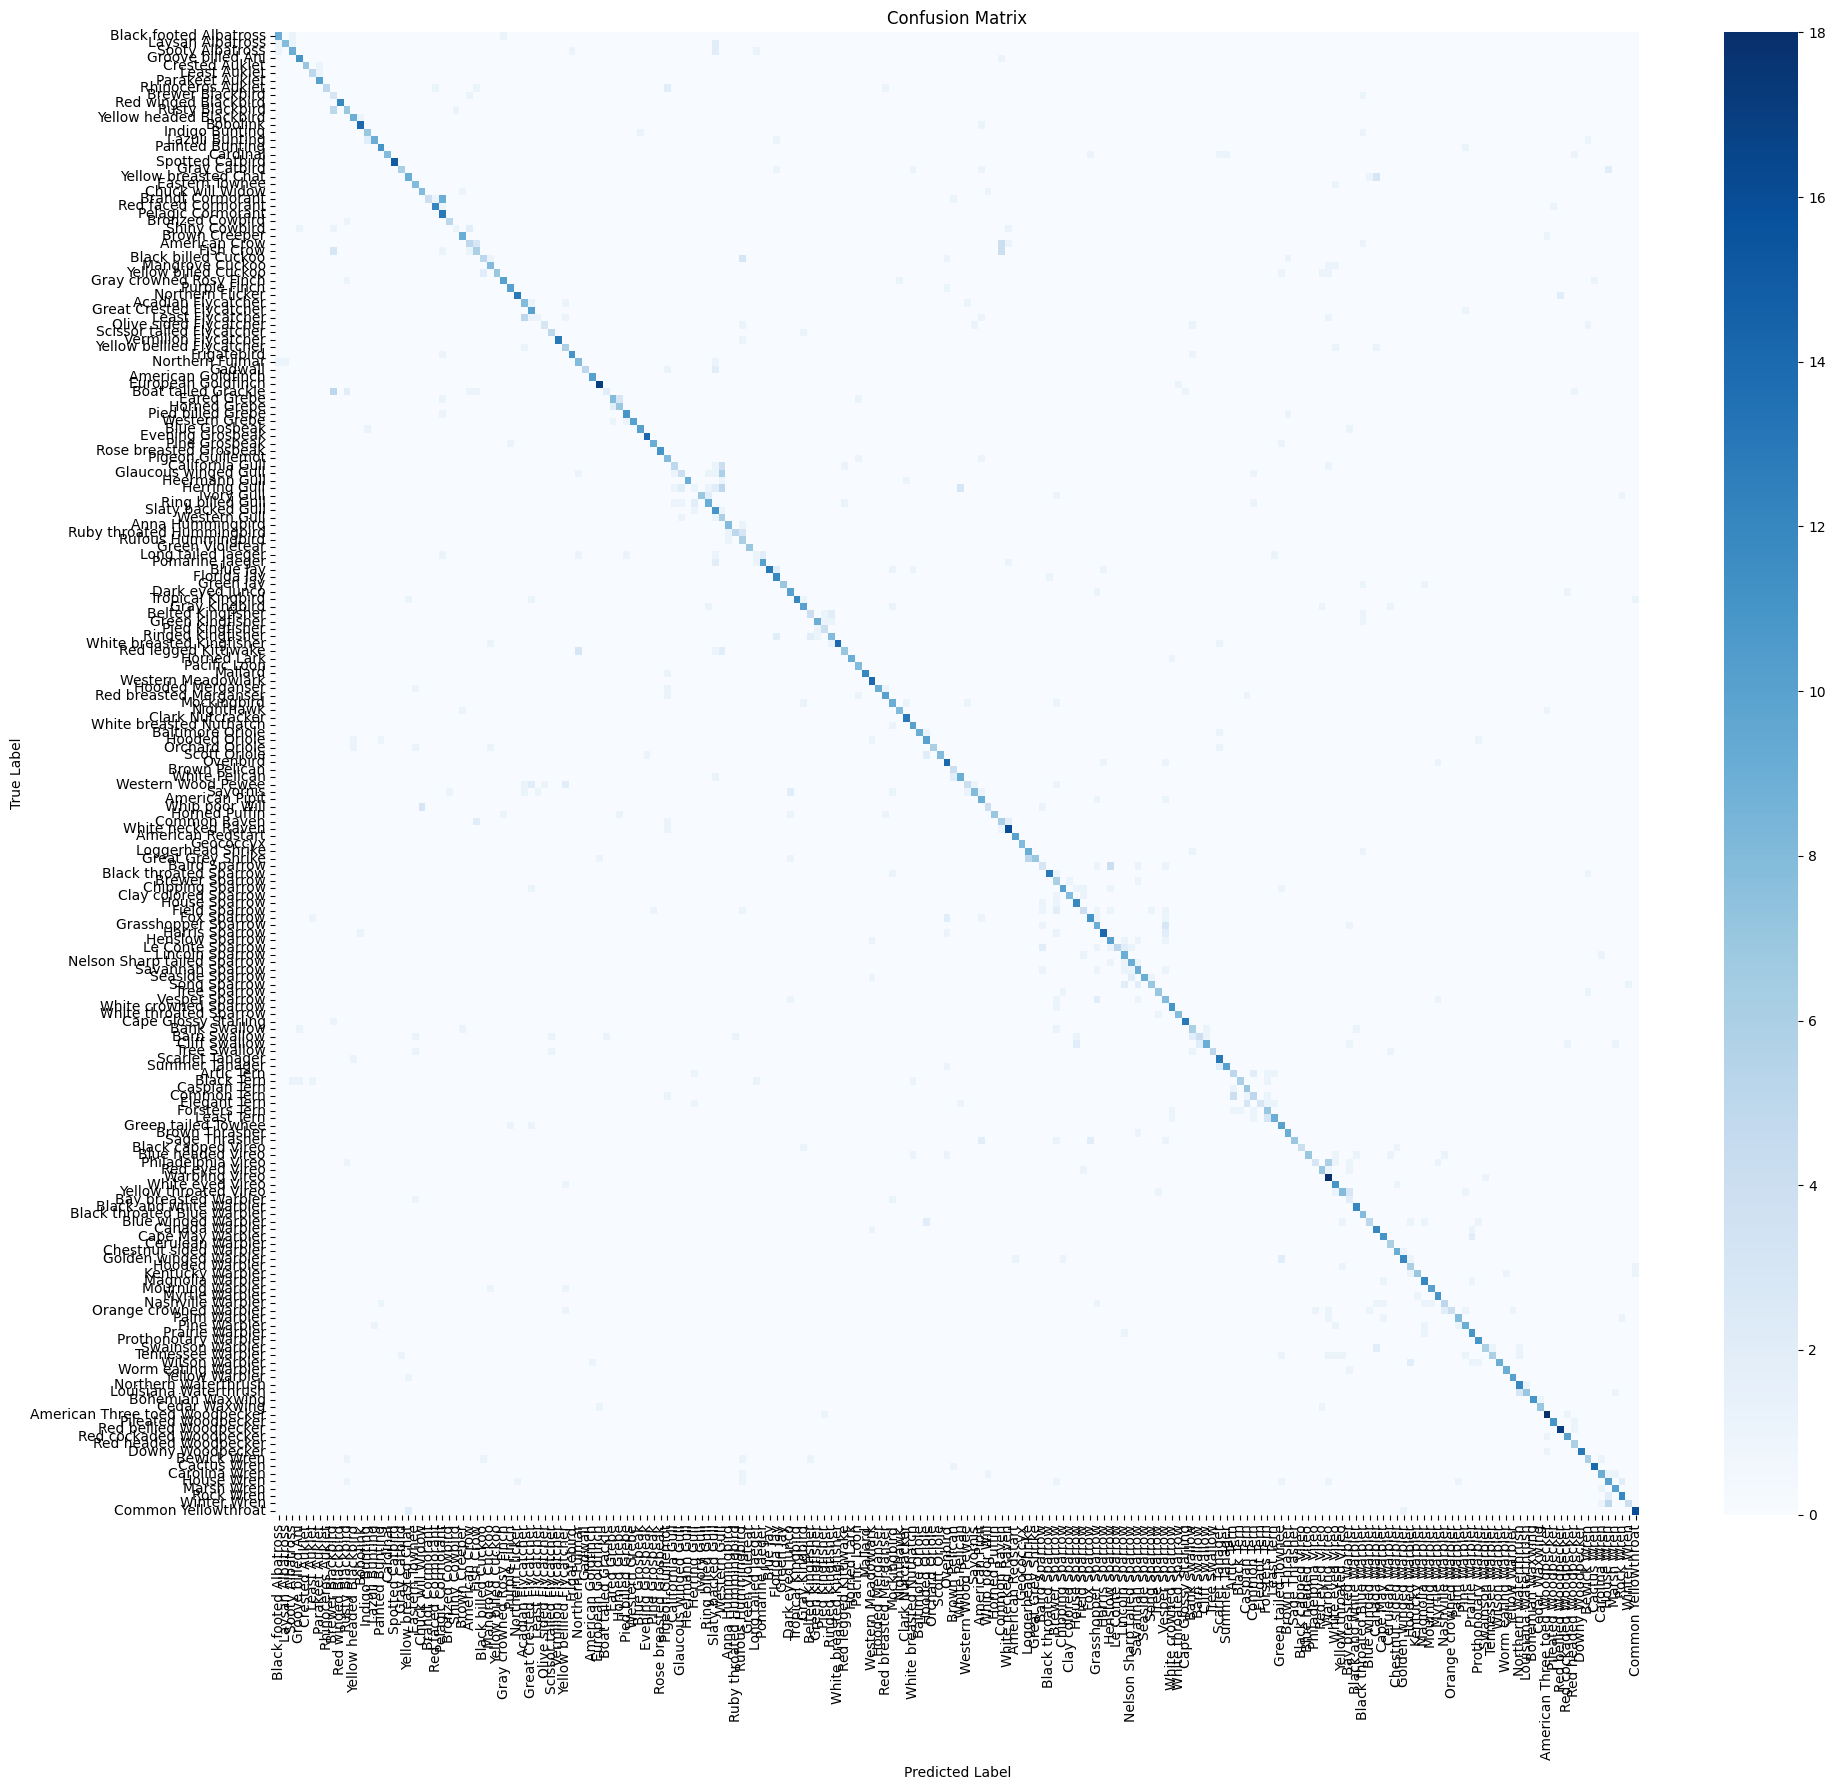


--- TOP 5 DES CONFUSIONS (hors diagonale) ---
⚠️ 9 erreurs : Vrai 'Brandt Cormorant'  --->  Prédit 'Pelagic Cormorant'
⚠️ 6 erreurs : Vrai 'Glaucous winged Gull'  --->  Prédit 'Western Gull'
⚠️ 6 erreurs : Vrai 'Philadelphia Vireo'  --->  Prédit 'Warbling Vireo'
⚠️ 5 erreurs : Vrai 'Rusty Blackbird'  --->  Prédit 'Brewer Blackbird'
⚠️ 5 erreurs : Vrai 'Least Flycatcher'  --->  Prédit 'Acadian Flycatcher'


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure idx_to_class is available
if 'idx_to_class' not in locals():
    classes_path = "/content/CUB_200_2011/classes.txt"
    classes_df = pd.read_csv(classes_path, sep=" ", header=None, names=["class_id", "class_name"])
    idx_to_class = {i: name.split('.')[1].replace('_', ' ') for i, name in enumerate(classes_df["class_name"])}

# Function to evaluate and visualize model performance
def evaluate_and_visualize_metrics(model, loader, device, idx_to_class):
    model.eval()
    all_preds = []
    all_labels = []

    print("Collecting predictions for evaluation...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluation Progress"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # --- 1. Classification Report (Precision, Recall, F1-score) ---
    print("\n--- Classification Report ---")
    target_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

    # --- 2. Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("\n--- Confusion Matrix (first 5x5 block) ---")
    print(cm[:5, :5]) # Print a small part as it's a 200x200 matrix

    # --- 3. Visualize Confusion Matrix (Heatmap) ---
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # --- 4. Top Confusions (similar to previous output) ---
    print("\n--- TOP 5 DES CONFUSIONS (hors diagonale) ---")
    np.fill_diagonal(cm, 0) # Set diagonal to 0 to find off-diagonal errors
    pairs = np.argwhere(cm > 0)
    confused_pairs = []
    for true_idx, pred_idx in pairs:
        count = cm[true_idx, pred_idx]
        confused_pairs.append((count, true_idx, pred_idx))
    confused_pairs.sort(key=lambda x: x[0], reverse=True)

    for count, true_idx, pred_idx in confused_pairs[:5]:
        true_name = idx_to_class[true_idx]
        pred_name = idx_to_class[pred_idx]
        print(f"⚠️ {count} erreurs : Vrai '{true_name}'  --->  Prédit '{pred_name}'")

# Execute the new evaluation function
evaluate_and_visualize_metrics(model, val_loader, device, idx_to_class)